# 我的第一个可调参数深度学习框架
在这个笔记中，我准备实现可以自定义深度学习框架，其中，可以定义的超参数如下
+ 学习率
+ 神经网络层数
+ 每一层神经网络的节点数
+ 每一层神经网络的激活函数

通过定义上面的参数，我们基本可以实现任意层数，任意输入的神经网络。


首先，深度学习框架的运算流程，如下如所示：
1. **正向传播，第L层的运算如下图所示：**
![layer_forward](img/layer_forwrad.png)
2. **反向传播，第L层的运算如下图所示**
![layer_backward](img/layer_backward.png)

因此，把每一层当做一个对象
在做抽象之前，我们先准备一些函数，包括**激活函数**，激活函数**导数**等一些函数

## 定义函数模块
### 定义函数名称

In [4]:
import numpy as np

METHOD_SIGMOID = "sigmoid"
METHOD_RELU = "ReLU"
METHOD_TANH = "tanh"
METHOD_LEAKY_RELU = "leaky ReLU"

### 激活函数模块

In [5]:
def tanh(z):
    """
    tanh函数
    :param z:神经网络计算W*A后的输出
    :return:tanh函数作用后的输出
    """
    return np.tanh(z)


def sigmoid(z):
    """
    sigmoid函数
    :param z: 神经网络计算W*A后的输出
    :return:sigmoid函数作用后的输出
    """
    return 1 / (1 + np.exp(-z))


def relu(z):
    """
    ReLU函数，这里使用numpy的where函数来进行实现
    :param z:神经网络计算W*A后的输出
    :return:ReLU函数作用后的输出
    """
    return np.where(z < 0, 0, z)


def leaky_relu(z, leaky=0.01):
    """
    带有泄漏的ReLU函数
    :param z:神经网络计算W*A后的输出
    :param leaky:泄漏函数小于零时的斜率，一般值要很小
    :return:leaky ReLU函数作用后的输出
    """
    return np.where(z < leaky * z, leaky * z, z)

### 定义激活函数导数模块

In [6]:
def sigmoid_derivative(z):
    """
    sigmoid函数的导数
    """
    return (1 - sigmoid(z)) * sigmoid(z)


def relu_derivative(z):
    """
    ReLU函数的导数
    """
    return np.where(z > 0, 1, 0)


def leaky_relu_derivative(z, leaky=0.01):
    """
    leaky ReLU 函数导数
    """
    return np.where(z > 0, 1, leaky)


def tanh_derivative(z):
    """
    tanh 函数导数
    """
    return 1 - tanh(z) * tanh(z)

### 定义根据名称获取特定函数的函数以及损失函数

In [18]:
def get_method(methodname):
    """
    根据函数名获取相关激活函数
    :param method:函数名
    :return:相关的激活函数
    """
    if methodname == METHOD_SIGMOID:
        return sigmoid
    elif methodname == METHOD_RELU:
        return relu
    elif methodname == METHOD_TANH:
        return tanh
    elif methodname == METHOD_LEAKY_RELU:
        return leaky_relu

def get_derivative(methodname):
    """
    根据函数名返回相关的激活函数导数
    :param method:函数名
    :return:相关的函数导数
    """
    if methodname == METHOD_SIGMOID:
        return sigmoid_derivative
    elif methodname == METHOD_RELU:
        return relu_derivative
    elif methodname == METHOD_TANH:
        return tanh_derivative
    elif methodname == METHOD_LEAKY_RELU:
        return leaky_relu_derivative

def lost_function(y, calculate_y):
    """
    损失函数
    :param y: 期望输出
    :param calculate_y:实际输出
    """
    return np.sum(-(y * np.log(calculate_y) + (1 - y) * np.log(1 - calculate_y))) / np.shape(y)[0]

## 定义层对象
上面我们把一些常见的激活函数和激活函数的导数都定义完成了，那么现在定义最关键的一步，定义层对象，根据上面的解释，层对象至少应该包含以下部分
+ **属性**
 - W
 - b
 - cacheZ
 - input

+ **method**
 - 计算向前输出get_output
 - 计算向后导数输出compute_derivative
 
 **下面是layer层全部代码**

In [19]:
class Layer(object):
    def __init__(self, w_shape, method, alpha):
        """
        初始化layer的
        :param w_shape:W参数的shape，类型应该是tuple，另外第一个参数是节点数，第二个参数是输入值的个数
        :param method:激活函数
        :param alpha: 学习率
        """
        self.method = get_method(method)
        self.derivative_method = get_derivative(method)
        self.W = np.random.randn(w_shape[0], w_shape[1]) * 0.01
        self.b = np.zeros((w_shape[0], 1))
        self.alpha = alpha

    def get_output(self, prea):
        """
        获取到本层的向前计算的计算结果
        :param prea:上一层的输出（这一层的输入）
        :return:这一层的计算结果
        """
        self.__cache_input(prea)
        z = np.dot(self.W, prea) + self.b
        self.__cache_z(z)
        return self.method(z)

    def compute_derivative(self, da):
        """
        计算上一层的导数，并在计算的过程中调整本层参数
        :param da:本层的导数
        :return:下一层的导数
        """
        dZ = da * self.derivative_method(self.cache_Z)
        self.compute_dw_db(dZ)
        return self.compute_pre_da(dZ)

    def __cache_z(self, z):
        """
        缓存Z的值
        :param z:要缓存的Z的值
        """
        self.cache_Z = z

    def __str__(self):
        return "W :" + str(np.shape(self.W)) + str(self.W) + "b :" + str(np.shape(self.b)) + str(self.b)

    def adjust_value(self, dW, db):
        """
        调整参数
        """
        self.W -= self.alpha * dW
        self.b -= self.alpha * db

    def __cache_input(self, a):
        """
        缓存一下输入
        :param a:这一层的输入
        """
        self.cache_input = a

    def compute_dw_db(self, dz):
        """
        计算这一层的dw和db并进行调整
        :param dz:
        :return:
        """
        m = dz.shape[1]
        dW = np.dot(dz, self.cache_input.T) / m
        db = np.sum(dz, axis=1, keepdims=True) / m
        self.adjust_value(dW, db)
        pass

    def compute_pre_da(self, dz):
        """
        计算上层的da
        :param dz:
        :return:
        """
        return np.dot(self.W.T, dz)


上面的代码中
在对象初始化中，我们初始化了Layer对象的，W，b，激活函数，激活函数导数以及学习率属性
在下面的方法中：
+ get_output(self, prea):

 根据上一层的输入获取到下一层的输出，对应上面的向前传播计算,其中在算法中我们缓存了输入prea以及计算出的中间变量z，因为在之后的计算中会用得到
 
+ compute_derivative(self, da):

 根据这一层的导数da获取上一层的导数preda，对应上面的向后传播计算，在这个函数里面，我们将导数计算分为了三部分，第一计算出dz，第二调用函数**compute_dw_db**根据dz计算dw和db，并调用函数**adjust_value**调整W和b参数，第三，调用函数**compute_pre_da**根据dz计算上一层的导数preda，之所以把这一个过程分开来进行计算，是为了后面的代码。下面会解释到

## 定义框架类
上面已经定义好了神经网络中的层的对象，下面我们就来写框架的类，来达到组织层对象的目的

**首先应该明确**
 一个框架类对应一个深度学习的网络模型
 因此应该在框架初始化的时候定义好下面几个东西
 
 1. 学习率
 2. 模型的层数
 3. 每一层的激活函数
 4. 每一层的节点数

In [20]:
class AIFrameWork(object):
    def __init__(self, nx, layer_nodes, methods, alpha):

        """
        初始化模型
        :param nx:要进行训练的训练集的维度
        :param layer_nodes:每一层的节点数，从第一层开始（不包含输入层）包含输出层
        :param methods 各层的激活函数
        :param alpha:学习率
        """
        self.layer_list = []
        self.init_layers(nx, layer_nodes, methods, alpha)

    def forward_compute(self, x):
        """
        计算正向传播
        :param x 输入值
        :return 神经网络的最终的预测值
        """
        last_input = x
        for layer_item in self.layer_list:
            last_input = layer_item.get_output(last_input)
        return last_input

    def backward_compute(self, y, y_calculate):
        """
        计算反向传播算法
        :param y_calculate 预测值
        :param y 预期值
        """
        # 直接计算出倒数第一层的dz，防止在计算导数过程中出现的除以零的情况
        last_layer_dz = y_calculate - y
        last_layer = self.layer_list[-1]
        last_layer.compute_dw_db(last_layer_dz)
        pre_da = last_layer.compute_pre_da(last_layer_dz)
        for layer_item in self.layer_list[-2::-1]:
            pre_da = layer_item.compute_derivative(pre_da)

    @staticmethod
    def show_lost_values(lost_values):
        import matplotlib.pyplot as plt
        plt.title("lost function trend")
        plt.xlabel("#iterate")
        plt.ylabel("cast")
        plt.plot(lost_values)
        plt.show()

    def train_layer(self, x, y, n_train=1000, show_lost=False):
        """
        对网络模型进行训练
        :param x:输入
        :param y:期望输出
        :param n_train 对单个训练集的训练次数
        :param show_lost 是否显示损失函数的变化情况，默认为不显示
        """
        lost_values = []
        for i in range(n_train):
            y_calculate = self.forward_compute(x)
            self.backward_compute(y, y_calculate)
            if show_lost:
                lost_value = lost_function(y, y_calculate)
                lost_values.append(lost_value)
        if show_lost:
            self.show_lost_values(lost_values)

    def init_layers(self, n_x, layer_nodes, methods, alpha):
        """
        初始化模型的每一层
        :param n_x:输入的维度
        :param layer_nodes:每一层的节点数
        :param methods:每一层的激活函数名称
        :param alpha:学习率
        :return:初始化完成的神经网络层的列表
        """
        for layer in range(len(layer_nodes)):
            if layer == 0:
                w_shape = (layer_nodes[layer], n_x)
            else:
                w_shape = (layer_nodes[layer], layer_nodes[layer - 1])
            self.layer_list.append(Layer(w_shape, methods[layer], alpha))
        print("init layer complete. layer list is" + str([str(item) for item in self.layer_list]))

上面我们已经实现了所有的代码，
在输出初始化的时候我们根据每一层的节点数和函数的这个参数初始化了所有的网络层

在方法**train_layer**我们分别调用**forward**和**backward**函数进行神经网络的计算，其中的showLost参数是为了观察损失值的变化，来查看训练到了什么程度
值得注意的是在向后传播**backward_compute**的算法中，我们直接把最后一层的导数计算了出来，这是因为最后一层的**da = -y/y_cal - (1-y)/(1-y_cal)**,如果预测值即**y_cal**的结果为1或者是0的时候，将会倒是计算错误，因此，将最后一层导数单独进行计算，而不是带入方程由**da**计算出来**dz**， 这样就减少了出现错误的问题。

另外，也可以看到，这个框架是在二分分类的基础上的的框架，里面的导数计算也是如此，因此，要想让框架正常工作需要下面两点：

 1. 框架必须是二分分类
 2. 最后一个层节点数量必须是1
 3. 最后一层的激活函数必须是sigmoid函数

另外，这个框架未加任何的优化策略，因此我们在下面的测试中可以看到，它不可避免的会出现损失函数呈锯齿状下降，下面来进行测试吧。


接下来就是进行测试了，例如我们如果想要实现一个3层,每层为4个节点，输入维度为3的深度学习框架，并且学习率为0.01的话那么就可以这样进行定义

```python
layer_nodes = np.array([4, 4, 1])
alpha = 0.01
methods = (METHOD_RELU, METHOD_RELU, METHOD_SIGMOID)
ai_model = AIFrameWork(3, layer_nodes, methods, alpha)
```
这里隐藏层的激活函数我们全部都使用了ReLU函数
下面是测试，我们仍旧使用之前使用的数据进行测试
实现的仍然是之前文件里面的单隐层网络
[3.11 （单隐藏层人工智能网络)](3.11 （单隐藏层人工智能网络）.ipynb)

## 测试

init layer complete. layer list is['W :(4, 3)[[-0.02040112  0.00635929  0.00550285]\n [ 0.00122742 -0.01549515  0.00136167]\n [ 0.0053168   0.01280098 -0.01165329]\n [ 0.01182547  0.00668149 -0.00582494]]b :(4, 1)[[ 0.]\n [ 0.]\n [ 0.]\n [ 0.]]', 'W :(1, 4)[[-0.00247357  0.00408811  0.0008681   0.00588481]]b :(1, 1)[[ 0.]]']


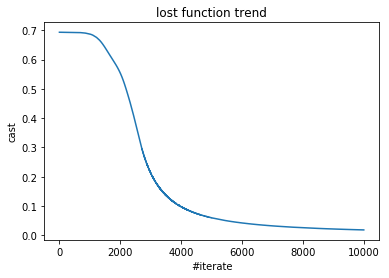

[[ 0.99114533  0.0328409   0.0328409   0.99956526  0.9968124   0.0328409 ]]


In [21]:
x = np.array([[1, 2, 4], [4, 6, 8], [4, 5, 6], [3, 5, 9], [2, 4, 0], [9, 2, 7]])

y = np.array([1, 0, 0, 1, 1, 0])

alpha = 0.01

layer_nodes = np.array([4,  1])

methods = (METHOD_RELU,  METHOD_SIGMOID)

ai_model = AIFrameWork(3, layer_nodes, methods, alpha)

ai_model.train_layer(x.T, y, n_train=10000, show_lost=True)

test_out = ai_model.forward_compute(x.T)

print(test_out)


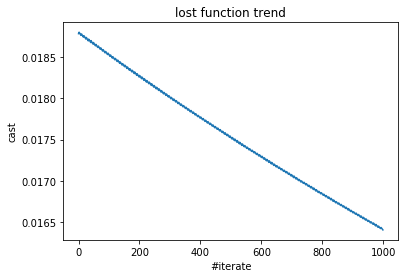

In [22]:
ai_model.train_layer(x.T, y, show_lost=True)

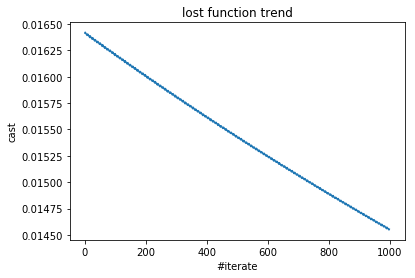

In [23]:
ai_model.train_layer(x.T, y, show_lost=True)

In [24]:
ai_model.forward_compute(x.T)

array([[ 0.99333023,  0.02566677,  0.02566677,  0.99972113,  0.99762479,
         0.02566677]])

#### 计算绝对误差

In [26]:
relative_error = (np.sum(np.abs(ai_model.forward_compute(x.T) - y)))/np.shape(y)[0] 
print("平均绝对误差为：" + str(relative_error))

平均绝对误差为：0.0143873595653


可以看到，这里在下降过程中的线条很粗，其实我们放大了看的话是下面的情况：
![lost_graph](img/lost_graph.png)
因此，可以看到，它的下降是在曲折的过程中逐渐下降的，在学习了第二节课后希望写出的模型能够下降的更快。能够减缓这种曲折的程度

另外，在测试模型的过程中，偶尔会出现模型训练失败的情况，我猜测可能是因为初始化的时候参数合适导致的吧

<a href="https://github.com/mengfly"><img height="80px" width="80px" src="img/erweima.png" alt="扫描二维码查看我的github"/></a>